In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import keras.backend as K
import tensorflow as tf
from keras.optimizers import Adam
from datagen import SequenceDataGenerator
from utils import *
from unet import UNet

Using TensorFlow backend.


In [2]:
LEARNING_RATE = 1e-4
NUM_SHAPE = 3
IMAGE_SIZE = 128
SEQUENCE_LEN = 10
EPOCHS = 1000
STEPS = 500

In [3]:
np.random.seed(1)
dg = SequenceDataGenerator(
    num_shape = NUM_SHAPE, 
    image_size = IMAGE_SIZE,
    sequence_len = SEQUENCE_LEN)

In [4]:
def masked_mse(y_true, y_pred):
    flow = y_true[:, :, :, 0:2]
    mask = y_true[:, :, :, 2:3]
    y_pred = tf.math.multiply(mask, y_pred)
    loss = K.mean(tf.square(flow - y_pred))
    return loss

In [5]:
model = UNet((IMAGE_SIZE, IMAGE_SIZE, 6), 2)
model.compile(optimizer = Adam(LEARNING_RATE), loss = masked_mse)
losses = []

In [7]:
model.load_weights('model/optical_flow.h5')

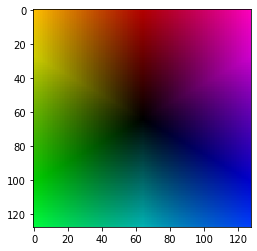

In [28]:
flow = np.zeros((128, 128, 2))
for i in range(128):
    for j in range(128):
        flow[i, j, 0] = j - 64
        flow[i, j, 1] = i - 64
flow = flow / 64
rgb = flow_to_rgb(flow)
plt.imshow(rgb)

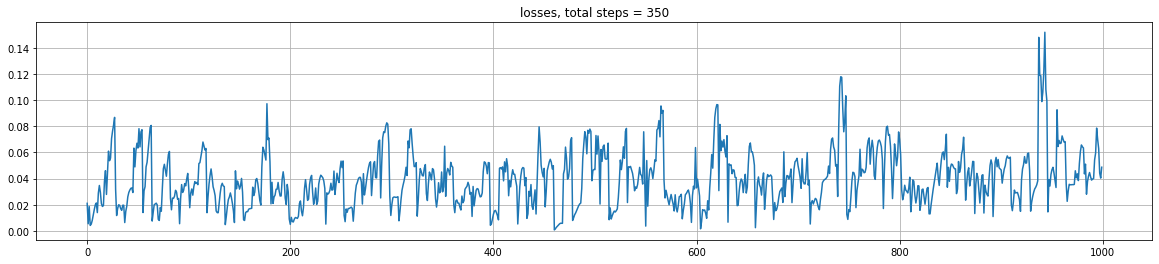

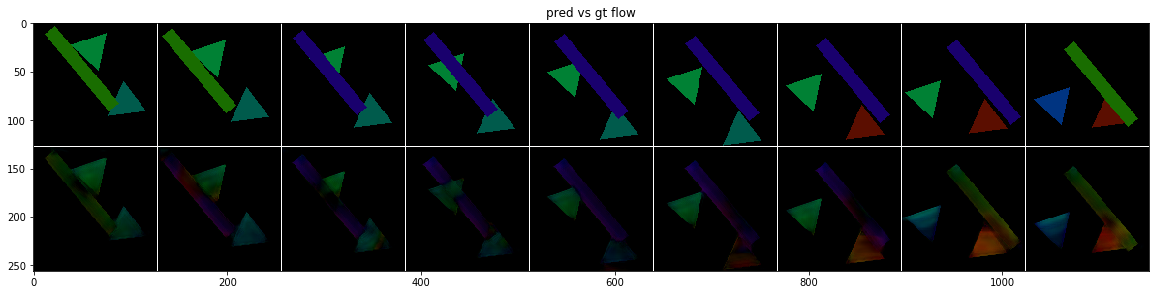

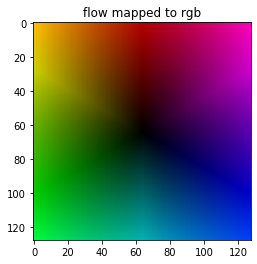

KeyboardInterrupt: 

In [29]:
for epoch in range(EPOCHS):
    # train
    for step in range(STEPS):
        sequence, flows = dg.get_sequence()
        for i in range(SEQUENCE_LEN - 1):
            img0 = sequence[i]['image']
            img1 = sequence[i+1]['image']
            mask = sequence[0]['class_mask'] != 0
            mask = np.expand_dims(mask, -1)
            stacked_imgs = np.concatenate((img0, img1), axis = -1)
            stacked_imgs = np.expand_dims(stacked_imgs, 0)
            flow = flows[i]
            flow_and_mask = np.concatenate((flow, mask), -1)
            flow_and_mask = np.expand_dims(flow_and_mask, 0)
            history = model.fit(stacked_imgs, flow_and_mask, verbose = False)
            losses.append(history.history['loss'][-1])
        if step % 10 == 0:
            clear_output(wait = True)
            plt.figure(figsize = (20, 4))
            plt.title(f'losses, total steps = {step}')
            plt.plot(losses[-1000:])
            plt.grid()
            # test
            sequence, flows = dg.get_sequence()
            board = np.zeros((IMAGE_SIZE * 2, IMAGE_SIZE * (SEQUENCE_LEN - 1), 3))
            for i in range(SEQUENCE_LEN - 1):
                img0 = sequence[i]['image']
                img1 = sequence[i+1]['image']
                stacked_imgs = np.concatenate((img0, img1), axis = -1)
                stacked_imgs = np.expand_dims(stacked_imgs, 0)
                flow = flows[i]
                flow_pred = model.predict(stacked_imgs)
                flow_pred = np.squeeze(flow_pred)
                board[:IMAGE_SIZE, (IMAGE_SIZE * i):(IMAGE_SIZE * (i+1)), :] = flow_to_rgb(flow)
                board[IMAGE_SIZE:, (IMAGE_SIZE * i):(IMAGE_SIZE * (i+1)), :] = flow_to_rgb(flow_pred)
            board[IMAGE_SIZE, :, :] = 1
            for i in range(SEQUENCE_LEN - 1):
                board[:, IMAGE_SIZE * i, :] = 1
            plt.figure(figsize = (20, 5))
            plt.title('pred vs gt flow')
            plt.imshow(board)
            plt.figure(figsize = (4, 4))
            plt.title('flow mapped to rgb')
            plt.imshow(rgb)
            plt.show()
            
    model.save(f'model/optical_flow.h5')